In [1]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Activation, Flatten, Input, BatchNormalization, Reshape, UpSampling2D, PReLU, ReLU, LeakyReLU, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.utils import to_categorical, plot_model

import numpy as np
import os
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import cv2
from multiprocessing import Pool
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from timeout_decorator import timeout, TimeoutError

from utils import *

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
noise_length=512
width=256
height=256
epochs=600
batch_size=128

In [4]:
conv_init = RandomNormal(0, 0.02)


def G_model(Height, Width, channel=3):

    inputs = Input((noise_length,))
    x = Dense((Height//16) * (Width//16) * 512)(inputs)
    x = LeakyReLU(0.2)(x)
    x = Reshape(((Height//16) , (Width//16), 512))(x)
    x = Conv2D(1024, 1, strides=1, padding="same",
               kernel_initializer=conv_init)(x)
    x = SubpixelConv2D(x)(x)  # 8x8x256
    x = LeakyReLU(0.2)(x)
    x = Conv2D(512, 1, strides=1, padding="same",
               kernel_initializer=conv_init)(x)
    x = SubpixelConv2D(x)(x)  # 16x16x128
    x = LeakyReLU(0.2)(x)
    x = Conv2D(256, 1, strides=1, padding="same",
               kernel_initializer=conv_init)(x)
    x = SubpixelConv2D(x)(x)  # 32x32x64
    x = LeakyReLU(0.2)(x)
    x = Conv2D(12, 1, strides=1, padding="same",
               kernel_initializer=conv_init)(x)
    x = SubpixelConv2D(x)(x)  # 64x64x3
    outputs = Activation("tanh", name="generator_output")(x)

    model = Model(inputs=inputs, outputs=outputs, name='generator')
    return model

def D_model(Height, Width, channel=3):
    inputs = Input((Height, Width, channel))
    x = Conv2D(64, (5, 5), padding="same", strides=(2,2))(inputs)
    x = MaxPooling2D(2)(x)
    x = LeakyReLU(0.2)(x)
    x = Conv2D(128, (5, 5), padding="same", strides=(2,2))(x)
    x = MaxPooling2D(2)(x)
    x = LeakyReLU(0.2)(x)
    x = Flatten()(x)
    x = Dropout(0.5) (x)
    x = Dense(1024)(x)
    x = LeakyReLU(0.2)(x)
    x = Dropout(0.5)(x)
    outputs = Dense(1, activation="sigmoid", name="discriminator_output")(x)
    model = Model(inputs=inputs, outputs=outputs, name="discriminator")
    return model
    

In [5]:
g = G_model(Height=height, Width=width, channel=3)
d = D_model(Height=height, Width=width, channel=3)
c = Combined_model(g=g, d=d)

In [6]:
g_opt = Adam(lr=0.0002, beta_1=0.5)
d_opt = Adam(lr=0.0002, beta_1=0.1)

In [7]:
g.compile(loss='binary_crossentropy', optimizer='SGD')
d.trainable = False
for layer in d.layers:
    layer.trainable = False
c.compile(loss='binary_crossentropy', optimizer=g_opt)

In [8]:
d.trainable = True
for layer in d.layers:
    layer.trainable = True
d.compile(loss='binary_crossentropy', optimizer=d_opt)

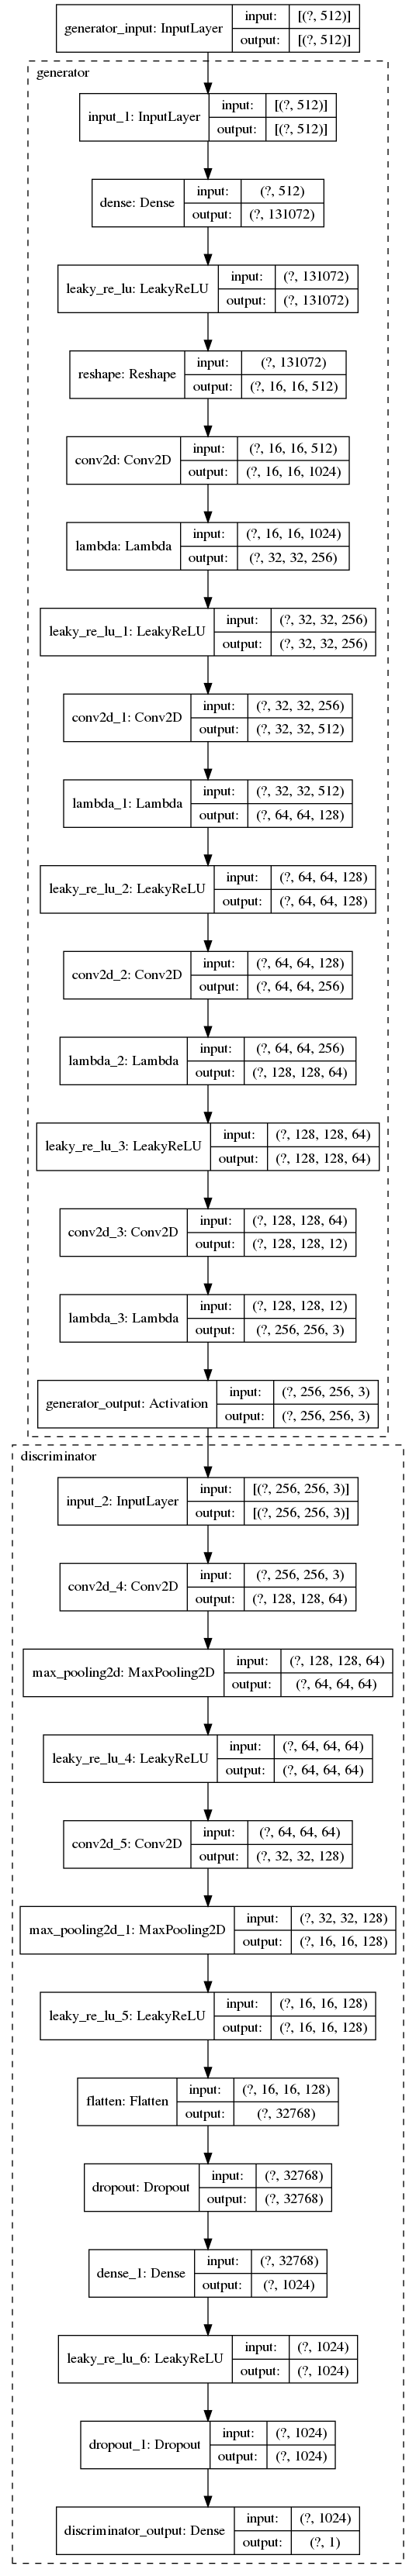

In [9]:
plot_model(c, show_shapes=True, expand_nested=True)

In [10]:
def read_file(filepath):
    img = cv2.imread(filepath)
    if img is None:
        print("no such file {0}".format(filepath))
        return
    _width, _height, _ = img.shape
    if _width<120 or _height< 120:
        return 
    img = cv2.resize(img, (width,height))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

In [11]:
folder="./faces"

with Pool() as p:
    imap = p.imap(read_file, [os.path.join(folder,path) for path in os.listdir(folder)])
    X = list(tqdm(imap, total=len(os.listdir(folder))))

X_train=[]
for img in X:
    if img is None:
        continue
    X_train.append(img)
    X_train.append(cv2.flip(img, 1))    
    #for i in range(4):
        #img = np.rot90(img)
        #X_train.append(img)
        #X_train.append(cv2.flip(img, 1))

del X, imap

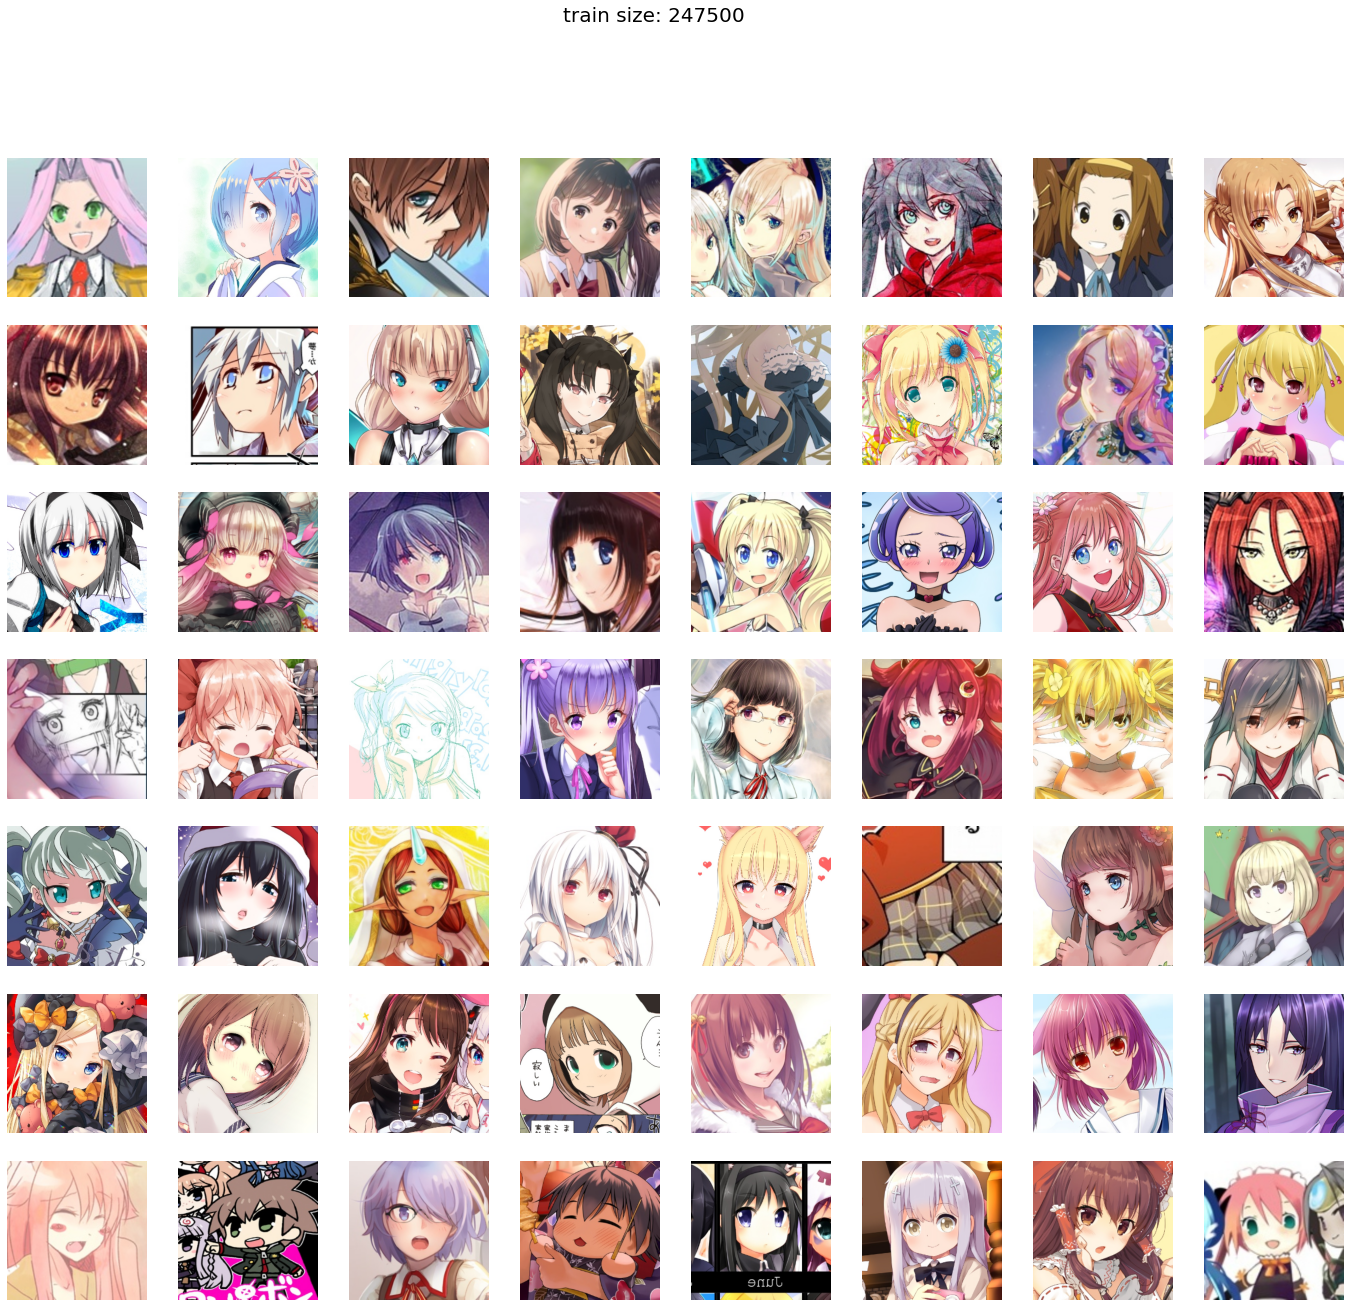

In [12]:
row = 7
col = 8
plt.figure(figsize=(col*3, row*3))
plt.suptitle("train size: {0}".format(len(X_train)), fontsize=20)
for i in range(row * col):
    plt.subplot(row, col, i+1)
    plt.imshow((random.choice(X_train)).astype(np.uint8))
    plt.axis('off')

In [13]:
g_losses = []
d_losses = []


g loss = 5.696005821228027, d loss = 0.15268199145793915


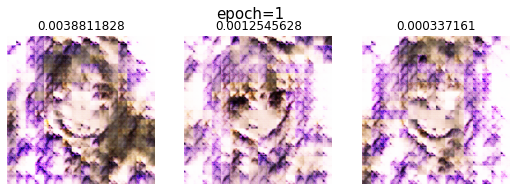


g loss = 3.87711763381958, d loss = 0.1618414968252182


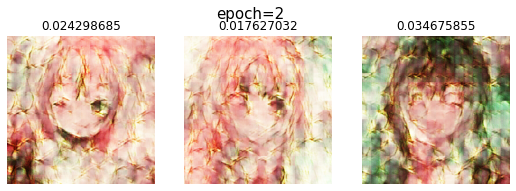


g loss = 3.8164799213409424, d loss = 0.14670193195343018


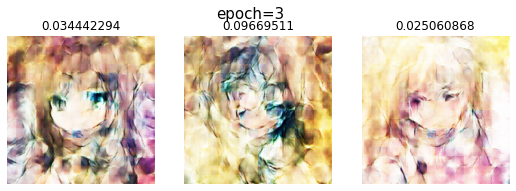


g loss = 3.3064582347869873, d loss = 0.16591864824295044


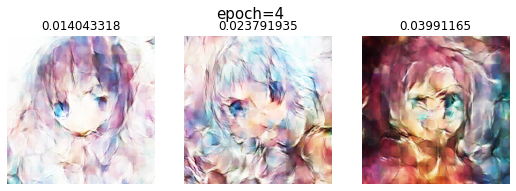


g loss = 3.2180795669555664, d loss = 0.17143411934375763


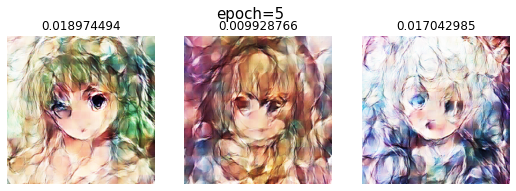


g loss = 3.090151786804199, d loss = 0.1954949051141739


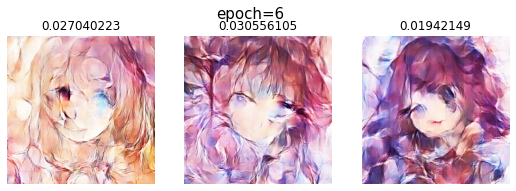


g loss = 3.200899124145508, d loss = 0.1723318248987198


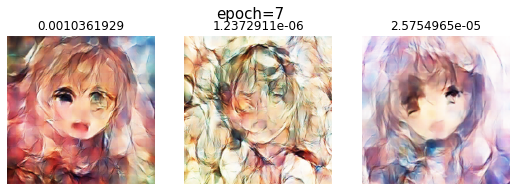


g loss = 3.108652114868164, d loss = 0.17922571301460266


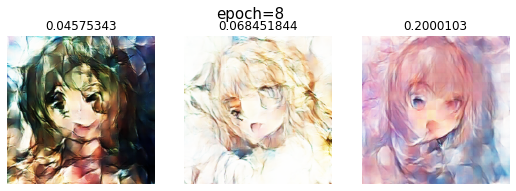


g loss = 3.2086782455444336, d loss = 0.1637047827243805


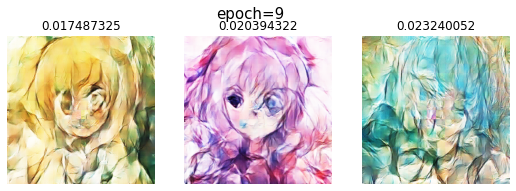


g loss = 3.305049180984497, d loss = 0.16744951903820038


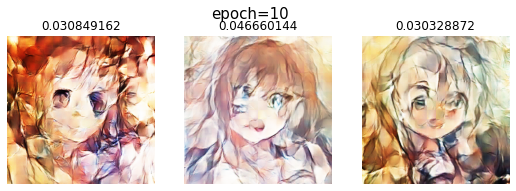


g loss = 3.3905839920043945, d loss = 0.13852569460868835


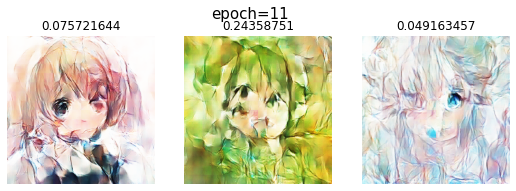


g loss = 3.4699864387512207, d loss = 0.14005960524082184


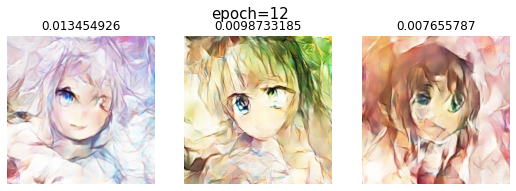


g loss = 3.2597174644470215, d loss = 0.20292361080646515


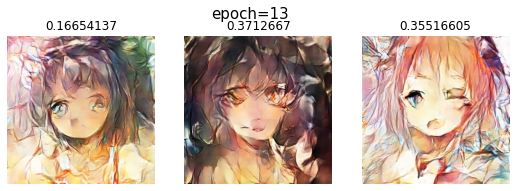


g loss = 3.5668323040008545, d loss = 0.1406775414943695


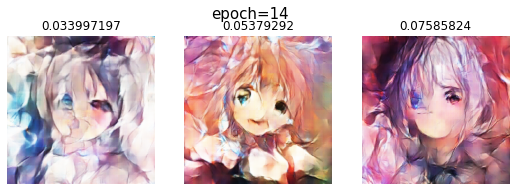


g loss = 3.580312967300415, d loss = 0.14733567833900452


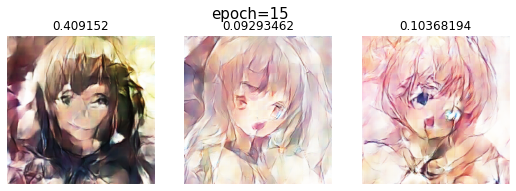


g loss = 3.495213747024536, d loss = 0.1266648769378662


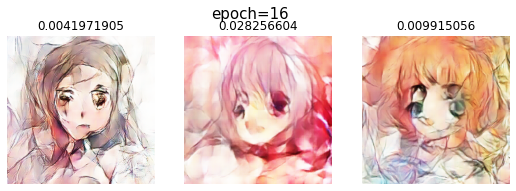


g loss = 3.399728298187256, d loss = 0.17447011172771454


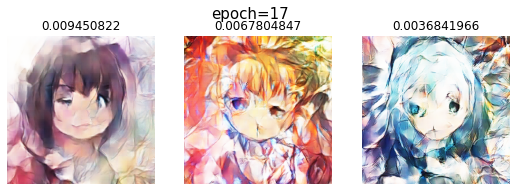


g loss = 3.431333541870117, d loss = 0.1850573867559433


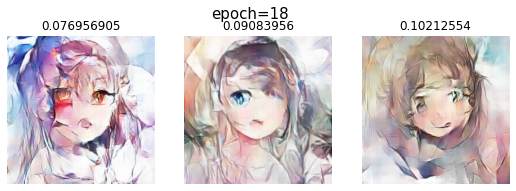


g loss = 3.5679738521575928, d loss = 0.12649092078208923


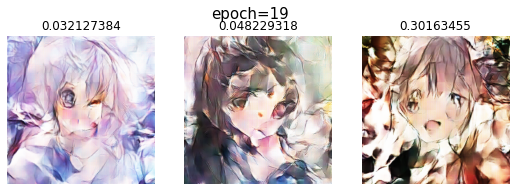


g loss = 3.7029991149902344, d loss = 0.11425549536943436


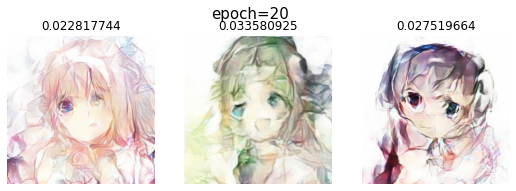


g loss = 3.8320040702819824, d loss = 0.1143331527709961


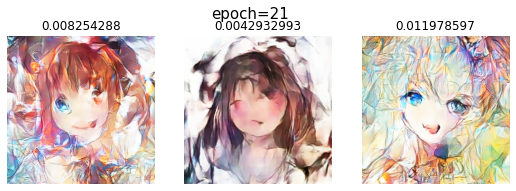


g loss = 3.723724842071533, d loss = 0.14126530289649963


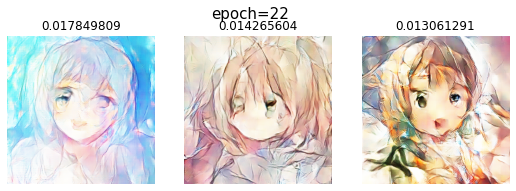


g loss = 3.842345714569092, d loss = 0.10542024672031403


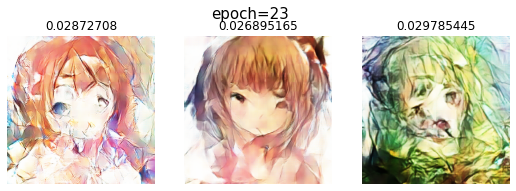


g loss = 3.714306116104126, d loss = 0.16253550350666046


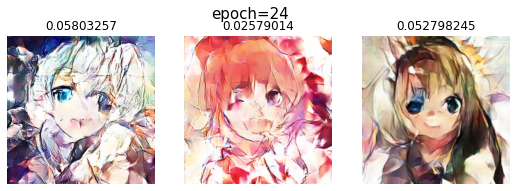


g loss = 3.8069982528686523, d loss = 0.10506457835435867


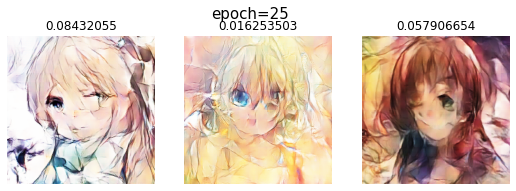


g loss = 3.979745864868164, d loss = 0.10323809087276459


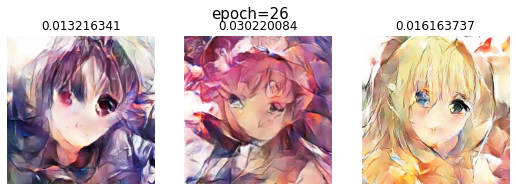


g loss = 3.93642520904541, d loss = 0.13086725771427155


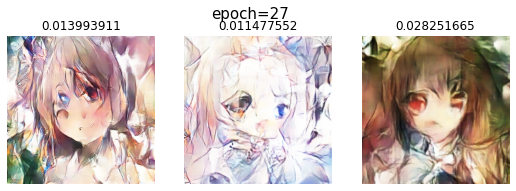


g loss = 3.974374532699585, d loss = 0.09786418825387955


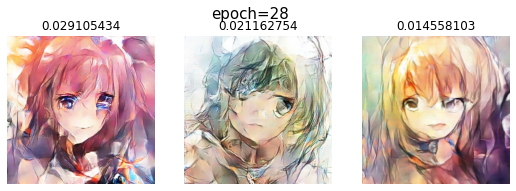


g loss = 3.9023139476776123, d loss = 0.12319783121347427


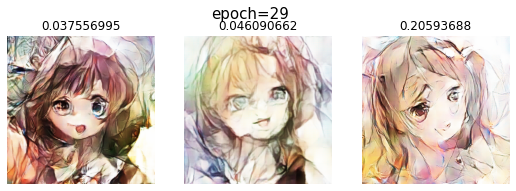


g loss = 4.057888507843018, d loss = 0.10652869194746017


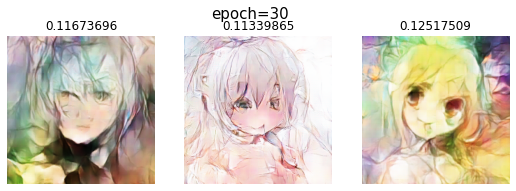

In [ ]:
for epoch in tqdm(range(1, epochs+1)):
    _g_losses = []
    _d_losses = []
    np.random.shuffle(X_train)
    for ite in tqdm(range(1, len(X_train)//batch_size+1)):
        # Discremenator training
        y = X_train[ite * batch_size: (ite+1) * batch_size]
        y = np.asarray(y)
        y = (y.astype(np.float32)-127.5)/127.5
        input_noise = np.random.uniform(-1, 1, size=(y.shape[0], noise_length))
        g_output = g.predict(input_noise, verbose=0)
        _X_train = np.concatenate((y, g_output))
        _Y_train = np.array([1] * y.shape[0] + [0] * y.shape[0])
        d_loss = d.train_on_batch(_X_train, _Y_train)
        _d_losses.append(d_loss)
        # Generator training
        input_noise = np.random.uniform(-1, 1, size=(batch_size*3, noise_length))
        g_loss = c.train_on_batch(input_noise, [1] * batch_size*3)
        _g_losses.append(g_loss)
    
    if epoch%5==0:
        g.save("./models/generator_{0}_{1}_{2}.h5".format(width,height,epoch))
        d.save("./models/discriminator_{0}_{1}_{2}.h5".format(width,height,epoch))
    g_losses.append(np.mean(_g_losses))
    d_losses.append(np.mean(_d_losses))
    print("g loss = {0}, d loss = {1}".format(g_losses[-1],d_losses[-1]))
    visualize(g,d,epoch,row=1,col=3)

In [ ]:
noise = np.random.uniform(-1, 1, size=(1, noise_length))
plt.imshow((g.predict(noise, verbose=0)[0]*127.5+127.5).astype(np.uint8))

In [ ]:
visualize(g,d)

In [ ]:
plt.plot(g_losses)

In [ ]:
plt.plot(d_losses)